In [1]:
import torch
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models, transforms
from torchvision.models import ResNet18_Weights
from PIL import Image
from tqdm.auto import tqdm

import lovely_tensors as lt
lt.monkey_patch()

from pathlib import Path
Path.ls = lambda x: list(x.iterdir())

In [2]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
model.eval()
model = model.to(device)

transform = ResNet18_Weights.IMAGENET1K_V1.transforms()

In [3]:
images_dir = Path('../data/example_images')
len(images_dir.ls())

50

tensor[1, 3, 224, 224] n=150528 (0.6Mb) x∈[-1.947, 2.570] μ=-0.114 σ=0.534 cuda:0


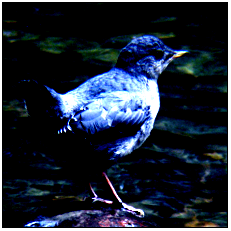

In [4]:
image = Image.open(images_dir.ls()[0])
t_image = transform(image).to(device)
batch = t_image.unsqueeze(0)
print(batch)
batch.rgb

In [5]:
import torch

means = torch.tensor([0.485, 0.456, 0.406]).to(device)
stds = torch.tensor([0.229, 0.224, 0.225]).to(device)

def norm(batch):
    return (batch - means.view(1, -1, 1, 1)) / stds.view(1, -1, 1, 1)

def denorm(batch):
    return batch * stds.view(1, -1, 1, 1) + means.view(1, -1, 1, 1)

def get_class_conf(model, batch):
    with torch.inference_mode():
        output = F.softmax(model(batch), dim=1)
        res_class_id = torch.argmax(output, 1)
        res_conf = output.gather(1, res_class_id[..., None])

        return res_class_id[0].item(), res_conf[0][0].item()


ref_class_id, ref_conf = get_class_conf(model, batch)
print(f"Started class was: {ref_class_id}, with confidence: {ref_conf:.6f}")

Started class was: 20, with confidence: 0.998181


  0%|          | 0/1000 [00:00<?, ?it/s]

Epsilon: 0.002745098039215686


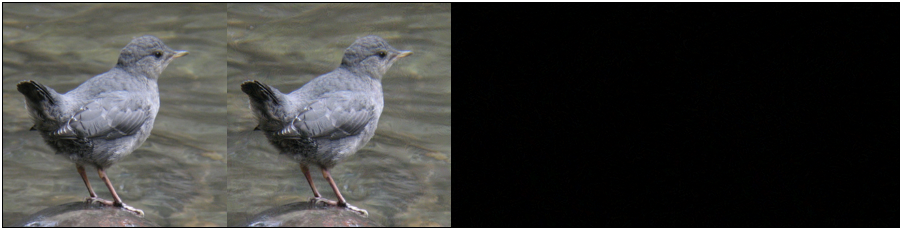

Started class was: 20, with confidence: 0.887962
Resulted class after adversarial noise: 0, with confidence: 0.941976


In [9]:
def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon*sign_data_grad
    return perturbed_image

def attack(model, input_image, target_class, epsilon, num_iterations, lambda_reg=0.05, verbose=True):
    perturbed_image = input_image.clone().detach().requires_grad_(True)
    target_tensor = torch.tensor([target_class], dtype=torch.long, device=input_image.device)

    progress = list(range(num_iterations))
    if verbose: progress = tqdm(progress)

    epsilon /= 255

    print(f"Epsilon: {epsilon}")
    
    for _ in progress:
        model.zero_grad()

        output = model(perturbed_image)
        loss_adv = -F.cross_entropy(output, target_tensor)
        
        loss_reg = lambda_reg * F.mse_loss(perturbed_image, input_image)
        loss = loss_adv + loss_reg

        loss.backward()

        perturbed_image.data = fgsm_attack(perturbed_image.data, epsilon, perturbed_image.grad.data)

        perturbed_image.grad.data.zero_()

        init_pred = output.max(1, keepdim=True)[1]
        if init_pred.item() == target_tensor.item():
            return perturbed_image.detach()
        if verbose:
            progress.set_description(f"Loss ce: {loss_adv.item():.6f}, loss mse: {loss_reg.item():.6f}")
        
    return perturbed_image.detach()

b_in = denorm(batch)
adv_example = attack(model, b_in, 0, epsilon=0.7, num_iterations=1000, lambda_reg=10)

bdiff = b_in - adv_example
adiff = adv_example - b_in

display(torch.cat([b_in, adv_example, bdiff, adiff], dim=3).rgb)

ref_class_id, ref_conf = get_class_conf(model, b_in)
print(f"Started class was: {ref_class_id}, with confidence: {ref_conf:.6f}")

res_class_id, res_conf = get_class_conf(model, adv_example)
print(f"Resulted class after adversarial noise: {res_class_id}, with confidence: {res_conf:.6f}")

# Inference on multiple images

In [8]:
examples = []
for i in tqdm(images_dir.ls()):
    image = Image.open(i)
    batch = transform(image).unsqueeze(0).to(device)
    denorm_batch = denorm(batch)
    adv_example = attack(model, denorm_batch, 0, epsilon=0.007, num_iterations=1000, lambda_reg=0.05, verbose=False)
    ref_class_id, ref_conf = get_class_conf(model, batch)
    res_class_id, res_conf = get_class_conf(model, adv_example)
    
    examples.append({
        "tensor": adv_example,
        "ref_class_id": ref_class_id,
        "ref_conf": ref_conf,
        "res_class_id": res_class_id,
        "res_conf": res_conf,
    })

  0%|          | 0/50 [00:00<?, ?it/s]

In [9]:
from collections import Counter
Counter([i['res_class_id'] for i in examples])

Counter({0: 50})

(array([ 1.,  0.,  1.,  0.,  0.,  2.,  5.,  4.,  7., 30.]),
 array([0.70890003, 0.73800699, 0.76711395, 0.7962209 , 0.82532786,
        0.85443482, 0.88354177, 0.91264873, 0.94175569, 0.97086264,
        0.9999696 ]),
 <BarContainer object of 10 artists>)

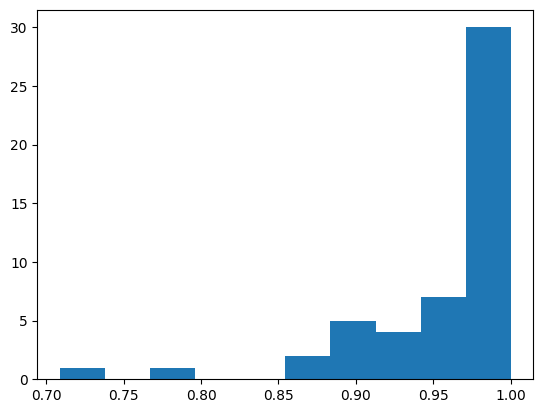

In [10]:
import matplotlib.pyplot as plt
confidences = [i['res_conf'] for i in examples]
plt.hist(confidences)